# Predict Magnetic Structure

In [1]:
import os
import re
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyhf3.read import ReadInfo
from pyhf3 import draw
from pyhf3 import magstr

In [313]:
name = 'baoso3'
path_input = 'input/%s/' % name.split('_')[0]
path_output = 'output/%s/' % name

info_path, info_cell = ReadInfo(path_input)

types = ['a', 'c', 'g']
types_dict = {'a':0, 'c':1, 'g':2}
types_dict_inv = {0:'a', 1:'c', 2:'g'}

figsize=(11, 6)
plt.rcParams.update({'font.size': 23})

"""
def DrawHeatmap(path_output, fn):
    df = pd.read_csv('%s/%s' % (path_output, fn))
    bins_range = sorted(list(set(df['bins'])))
    eta_range = sorted(list(set(df['eta'])))
    
    df = df.sort_values(by=['bins', 'eta'])
    data = df['acc'].to_numpy().reshape((len(bins_range), len(eta_range))).T
    
    fig, ax = plt.subplots(figsize=(14, 6))
    ms = ax.matshow(data, cmap='Blues')
    cb = plt.colorbar(ms, shrink=0.9, format='%.2f')
    
    acc_max = 0
    coord = (0, 0)
    for (i, j), z in np.ndenumerate(data):
        #ax.text(j, i, '{:0.2f}'.format(z), size=13, ha='center', va='center', c='white')
        if z > acc_max:
            acc_max = z
            coord = (j, i)
            
    #ax.text(coord[0], coord[1], '{:0.2f}'.format(acc_max), size=13, ha='center', va='center', c='white')
    ax.scatter(coord[0], coord[1], s=150, c='white', marker='*')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(range(0, len(bins_range)))
    ax.set_yticks(range(0, len(eta_range)))
    ax.set_xticklabels(bins_range, rotation=45)
    ax.set_yticklabels(eta_range)
    ax.set_xlabel('Interval')
    ax.set_ylabel('Broadening scale')
    print(coord, acc_max)
    plt.show()
    
def DrawOptEta(path_output, fn, bins):
    df = pd.read_csv('%s/%s' % (path_output, fn))
    df = df[df['bins'] == bins]
    data = df[['eta', 'acc']].to_numpy()
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(data[:, 0], data[:, 1], '.-', ms=20)
    ax.grid(True)
    yticks = [i for i in np.arange(0.90, 0.97, 0.01)]
    ax.set_yticks(yticks)
    ax.set_yticklabels(['%.2f' % i for i in yticks])
    ax.set_xlabel('Broadening scale')
    ax.set_ylabel('Accuracy')
    plt.show()
"""

def GetIdx0(df):
    for i in df.index:
        data = df.loc[i, :]
        dn = '%s/JU%.2f_SOC%.2f/' % (path_output, data['JU'], data['SOC'])
        d = [f for f in os.listdir(dn) if\
             re.match('band_.+N%.1f_U%.1f_.+m%f_.+fermi%f_' %\
                      (data['N'], data['U'], data['m'], data['fermi']), f)]
        df.loc[i, 'type'] = re.sub('band_', '',\
                                   re.search('band_[a-z]+\d?', d[0]).group())
    
    df['type_f'] = df['type_f'].replace(types_dict_inv)
    
    return df

def DrawHist(df, title, params, n):
    bins = len(df.columns) - len(params)
    hist = df.drop(params, axis=1).sum()
    x = hist.index.to_list()
    
    xt = np.arange(0, len(x), bins//n, dtype=int)
    xt = np.append(xt, len(x)-1)
    
    fig, ax = plt.subplots(figsize=figsize, dpi=500)
    ax.bar(x, hist)
    ax.set_xticks([x[i] for i in xt])
    ax.set_title(title, loc='left')
    plt.show()

def DrawConfusionMatrix(y_test, y_pred, title):
    from sklearn.metrics import ConfusionMatrixDisplay
    
    fig, ax = plt.subplots(figsize=figsize)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true', cmap='Blues', values_format='.2f', ax=ax)
    ax.set_title(title, loc='left')
    plt.show()
    
def DrawROC(y_test, y_score, title):
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc
    
    y_testb = label_binarize(y_test, classes=types)
    n_classes = y_testb.shape[1]
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    fig, ax = plt.subplots(figsize=figsize)
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_testb[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        ax.plot(fpr[i], tpr[i], label='%s (%.3f)' % (types[i], roc_auc[i]))

    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title, loc='left')
    ax.legend(loc="lower right")
    plt.show()
    
def DrawInput(df, title, prefix=''):
    alpha = 0.5
    bins0 = [len(np.unique(df['JU'])), len(np.unique(df['N']))//4, len(np.unique(df['U']))]
    xlim = [[-0.01, 0.31], [0, 12], [-0.1, 5.1]]
    
    for i, v in enumerate(['JU', 'N', 'U']):
        fig, ax = plt.subplots(figsize=figsize)
        _, bins = np.histogram(df[v], bins=bins0[i])
        for j, t in enumerate(types):
            df[df['type'] == j].hist(column=[v], ax=ax, bins=bins, alpha=alpha, label=t)
        ax.set_xlim(xlim[i])
        ax.legend()
        ax.set_title('%s%s\n'%(prefix,v)+title, loc='left')
        plt.title('')
    plt.show()

def DrawOutput(df, title, prefix='', zoom=False):
    bins0 = 50
    bins_ins0 = 20
    alpha = 0.5
    xlim = [[-0.1, 6.1], [], []]
    xlim_ins = [[-0.1, 1], [0, 10], [-0.1, 0.5]]
    
    for i, v in enumerate(['m', 'dntop', 'gap']):
        fig, ax = plt.subplots(figsize=figsize)
        _, bins = np.histogram(df[v], bins=bins0)
        for j, t in enumerate(types):
            df[df['type'] == j].hist(column=[v], ax=ax, bins=bins, alpha=alpha, label=t)

        if zoom:
            ins = ax.inset_axes([0.4,0.6,0.3,0.3])
            _, bins_ins = np.histogram(df[v], bins=bins_ins0)
            for j, t in enumerate(types):
                df[df['type'] == j].hist(column=[v], ax=ins, bins=bins_ins, alpha=alpha, label=t)
            ins.set_xlim(xlim_ins[i])
            ins.set_title('')
        if len(xlim[i]): ax.set_xlim(xlim[i])
        ax.legend()
        ax.set_title('%s%s\n'%(prefix,v)+title, loc='left')
        plt.title('')
    plt.show()
    
def DrawType(df, title, prefix=''):
    fig, ax = plt.subplots(figsize=figsize)
    
    df.hist(column=['type'], ax=ax)
    
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(types)
    ax.set_xlim([-0.1, 2.1])
    ax.set_ylim([0, 1800])
    ax.set_title('%stype\n'%(prefix)+title, loc='left')
    plt.title('')
    plt.show()
    
def DrawMisType(df, title):
    bins0 = len(types)
    alpha = 0.5
    
    fig, ax = plt.subplots(figsize=figsize)
    _, bins = np.histogram(df['type'], bins=bins0)
    for i, t in enumerate(types):
        df[df['type_f'] == i].hist(column=['type'], ax=ax, bins=bins, alpha=alpha, label=types[i])
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(types)
    ax.set_xlim([-0.1, 2.1])
    ax.legend()
    ax.set_title('misclassifed type\n'+title, loc='left')
    plt.title('')
    plt.show()
    
def DrawCorr(df):
    fig, ax = plt.subplots(figsize=figsize)
    corr = df.loc[:, ['JU', 'N', 'U', 'm', 'dntop', 'gap']].corr()
    sns.heatmap(corr, annot=True, fmt='.1f', ax=ax)
    plt.show()
    
def DrawImp(rf, bins, feature_names, title):
    estimators = rf.estimators_
    importances = rf.feature_importances_
    forest_importances = pd.Series(importances, index=feature_names)
    
    xt = np.arange(0, len(feature_names), bins//4, dtype=int)
    xt = np.append(xt, len(feature_names)-1)

    fig, ax = plt.subplots(figsize=(25, 6))
    std = np.std([importances for tree in estimators], axis=0)
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_xticks(xt)
    ax.set_title("Feature importances %s" % title)
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    
def DrawResult(dtype, bins, eta, tol, mcn, rspn, prefix, title, n=8):      
    from sklearn.metrics import accuracy_score
    
    # df_dos(input)
    df_dos = pd.read_csv('%s/magstr/dos_dt%s_bins%d_eta%.3f_tol%.3f.csv' %\
                         (path_output, dtype, bins, eta, tol), sep=',', index_col=0)

    ms = magstr.MagStr(path_output, info_path, info_cell)
    rf, idxs, X_test, y_test = ms.LearnOrTune(dtype, bins, eta, tol, mcn, rspn)
    
    y_pred = rf.predict(X_test)
    y_score = rf.predict_proba(X_test)
    df_sc = pd.DataFrame(y_score, columns=[0, 1, 2], index=y_test.index)
    
    if mcn == 'xgb':
        oh_dict = {
            '0':y_test.columns[0],
            '1':y_test.columns[1],
            '2':y_test.columns[2],
        }
        y_test = y_test.idxmax(axis=1)
        y_pred = np.array([oh_dict[str(np.argmax(y))] for y in y_pred])
    acc = accuracy_score(y_test, y_pred)
    
    # df_test
    df_test = df_dos.loc[y_test.index.to_list(), :]
    df_test['score'] = list(map(str, y_score))
    
    # df_rsp
    df_rsp = df_dos.loc[idxs, :]
    
    # df_exc
    idxs_exc = [i for i in df_dos.index.to_list() if not i in idxs]
    df_exc = df_dos.loc[idxs_exc, :]
    
    # df_mis
    mis_idx = []
    f_list = []
    for i, y_true in enumerate(y_test):
        if(y_true != y_pred[i]):
            mis_idx.append(y_test.index[i])
            f_list.append(y_pred[i])
    df_mis = df_dos.loc[mis_idx, :]

    # add misclassified type at df_mis
    df_mis['type_f'] = 0
    df_test['type_f'] = 0
    for i, idx in enumerate(mis_idx):
        df_mis.loc[idx, 'type_f'] = f_list[i]
        df_test.loc[idx, 'type_f'] = f_list[i]

    df_dos['type'] = df_dos['type'].replace(types_dict)
    df_rsp['type'] = df_rsp['type'].replace(types_dict)
    df_exc['type'] = df_exc['type'].replace(types_dict)
    df_mis['type'] = df_mis['type'].replace(types_dict)
    df_mis['type_f'] = df_mis['type_f'].replace(types_dict)
    df_test['type_f'] = df_test['type_f'].replace(types_dict)
    df_sc['tf'] = 0
    df_sc.loc[mis_idx, 'tf'] = 1
    
    #l = [f for f in df_sc.values]
    l  = [np.max(f[0:3]) for f in df_sc.values if f[3] == 1]
    lt = [np.max(f[0:3]) for f in df_sc.values if f[3] == 0]
    
    l_sum = np.sum(l)
    lt_sum = np.sum(lt)
    print(l_sum / len(l))
    print(lt_sum / len(lt))
    
    print('accuracy = %d/%d = %.4f' % ((len(y_pred)-len(df_mis)), len(y_pred), acc))
    print('Total # of data after resampling : %s → %s' % (len(df_dos), len(df_rsp)))
    
    if   prefix == 'resampled '    : df = df_rsp
    elif prefix == 'excluded '     : df = df_exc
    elif prefix == 'misclassified ': df = df_mis
    else:
        print('no prefix')
        df = df_dos

    #print(len(df_dos))
    #DrawHist(df_dos, title=title, params=ms.params, n=n)
    #DrawConfusionMatrix(y_test, y_pred, title=title)
    #DrawROC(y_test, y_score, title=title)
    #DrawType(df, title=title, prefix=prefix)
    #DrawMisType(df_mis, title=title)
    #DrawInput(df, title=title, prefix=prefix)
    #DrawOutput(df, title=title, prefix=prefix, zoom=False)
    #DrawImp(rf, bins, [c for c in df_dos.columns.to_list() if not c in ms.params], title=title)
    
    return df_dos, df_test, df_mis

def Applicate(dtype1, dtype2, bins, eta, tol, mcn, rspn, title):      
    from sklearn.metrics import accuracy_score

    df1 = pd.read_csv('%s/magstr/dos_dt%s_bins%d_eta%.3f_tol%.3f.csv' %\
                     (path_output, dtype1, bins, eta, tol), sep=',', index_col=0)
    df2 = pd.read_csv('%s/magstr/dos_dt%s_bins%d_eta%.3f_tol%.3f.csv' %\
                     (path_output, dtype2, bins, eta, tol), sep=',', index_col=0)

    ms = magstr.MagStr(path_output, info_path, info_cell)
    rf, idxs, X_test, y_test = ms.LearnOrTune(dtype1, bins, eta, tol, mcn, rspn)
    
    X_app = df2.drop(ms.params, axis=1)
    y_app = df2['type']
    y_pred = rf.predict(X_app)
    y_score = rf.predict_proba(X_test)
    
    if mcn == 'xgb':
        oh_dict = {
            '0':y_test.columns[0],
            '1':y_test.columns[1],
            '2':y_test.columns[2],
        }
        y_test = y_test.idxmax(axis=1)
        y_pred = np.array([oh_dict[str(np.argmax(y))] for y in y_pred])
    acc = accuracy_score(y_app, y_pred)
    
    mis_idx = []
    for i, y_true in enumerate(y_app):
        if(y_true != y_pred[i]):
            mis_idx.append(y_app.index[i])
    print('accuracy = %d/%d = %.4f' % ((len(y_pred)-len(mis_idx)), len(y_pred), acc))
    
    DrawConfusionMatrix(y_app, y_pred, title=title)

In [213]:
dt = '2-0-0'
bins = 100
eta = 0.1
tol = 1.0
test_list = []
mis_list = []

mcn = [['rf', 'RandomForest'],
       ['xgb', 'XGBoost'],
       ['lgb', 'LightGBM'],
       ['cat', 'CatBoost'],
       ['lr', 'LinearRegression']
      ]

for name, name_full in mcn:
    df_dos, df_test, df_mis = DrawResult(dt, bins, eta, tol, name, '', '', 'LDOS '+ name_full)
    test_list.append(df_test)
    mis_list.append(df_mis)
    
mis_idcs = [df.index.to_list() for df in mis_list[:-1]]
com_mis_list = list(set(mis_idcs[0]) & set(mis_idcs[1]) & set(mis_idcs[2]) & set(mis_idcs[3]))
com_well_list = list(set(df_test.index.to_list()) - set(mis_idcs[0] + mis_idcs[1] + mis_idcs[2] + mis_idcs[3]))

print(test_list[0].loc[com_mis_list, :])
print(test_list[0].loc[com_well_list, :])

Learn(rf--output/baoso3//magstr/dos_dt2-0-0_bins100_eta0.100_tol1.000.csv) : 0.871108s
0.5781578947368421
0.8400094339622641
accuracy = 1060/1098 = 0.9654
Total # of data after resampling : 3660 → 3660
no prefix
Learn(xgb--output/baoso3//magstr/dos_dt2-0-0_bins100_eta0.100_tol1.000.csv) : 0.769802s
0.6716655185229556
0.9711492620655711
accuracy = 1055/1098 = 0.9608
Total # of data after resampling : 3660 → 3660
no prefix
Learn(lgb--output/baoso3//magstr/dos_dt2-0-0_bins100_eta0.100_tol1.000.csv) : 0.974505s
0.7482073021134602
0.9808861360740743
accuracy = 1072/1098 = 0.9763
Total # of data after resampling : 3660 → 3660
no prefix
Learn(cat--output/baoso3//magstr/dos_dt2-0-0_bins100_eta0.100_tol1.000.csv) : 3.605457s
0.6864385048378482
0.9559151063791638
accuracy = 1073/1098 = 0.9772
Total # of data after resampling : 3660 → 3660
no prefix
Learn(lr--output/baoso3//magstr/dos_dt2-0-0_bins100_eta0.100_tol1.000.csv) : 1.356780s
0.6571674482635886
0.8172814818071904
accuracy = 861/1098 = 0.

output/baoso3//JU0.10_SOC0.00/band_a2_N3.4_U4.0_n3.3988907126142163_m3.1576998227007511_e25.9753335706587265_gap0.0022965738283407_fermi8.4965420118495381_dntop8.4961740181772374_1220124.txt


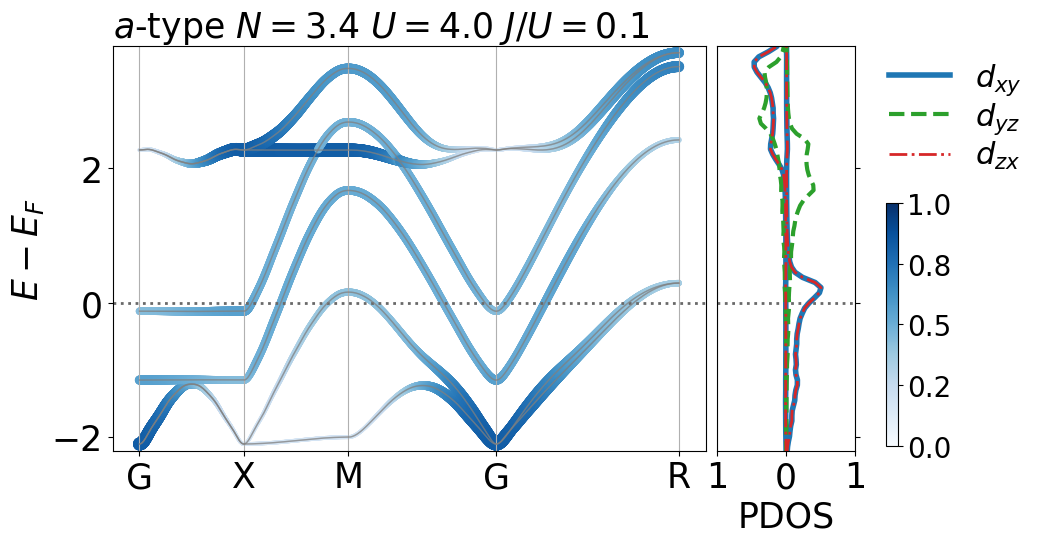

output/baoso3//JU0.10_SOC0.00/band_a2_N2.6_U3.5_n2.6023031892650756_m1.8065926588785850_e17.4195474723899366_gap0.0030230510341083_fermi7.3207022173277938_dntop7.3183741386429588_1220114.txt


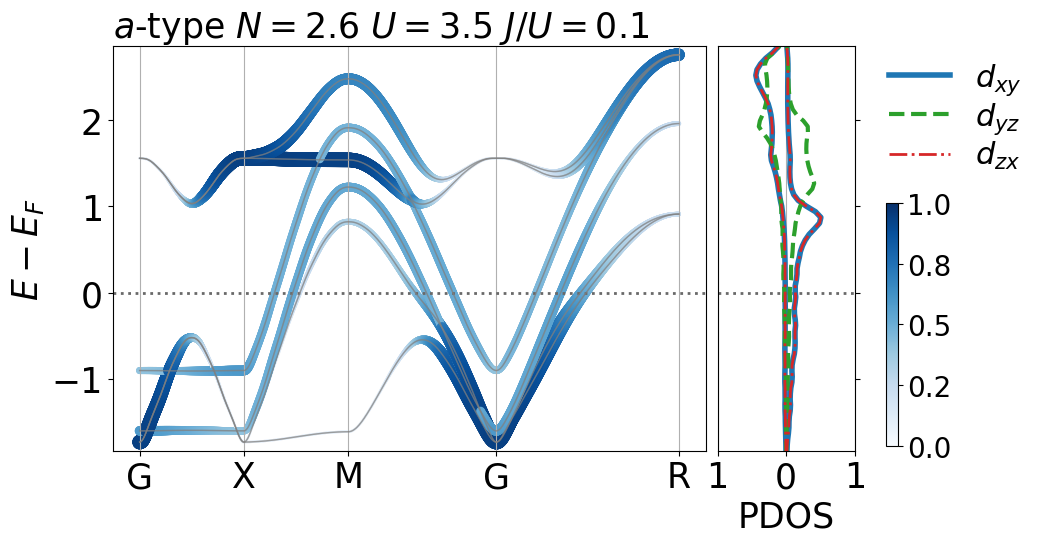

In [315]:
dr = draw.Draw(path_input, path_output, info_path, info_cell, 0.1, 0)
dr.DrawBandDOS('a2', 3.4, 4, 1)
dr.DrawBandDOS('a2', 2.6, 3.5, 1)

In [207]:
dt = '1-0-0'
bins = 100
eta = 0.5
tol = 1.0
test_list = []
mis_list = []

mcn = [['rf', 'RandomForest'],
       ['xgb', 'XGBoost'],
       ['lgb', 'LightGBM'],
       ['cat', 'CatBoost'],
       ['lr', 'LinearRegression']
      ]

for name, name_full in mcn:
    _, df_test, df_mis = DrawResult(dt, bins, eta, tol, name, '', '', r'$\bf k$PDOS ' + name_full)
    test_list.append(df_test)
    mis_list.append(df_mis)
    
mis_idcs = [df.index.to_list() for df in mis_list[:-1]]
com_list = list(set(mis_idcs[0]) & set(mis_idcs[1]) & set(mis_idcs[2]) & set(mis_idcs[3]))

test_list[0].loc[com_list, :]

Learn(rf--output/baoso3//magstr/dos_dt1-0-0_bins100_eta0.500_tol1.000.csv) : 2.318459s
0.6088888888888889
0.9455739210284665
accuracy = 1089/1098 = 0.9918
Total # of data after resampling : 3660 → 3660
no prefix
Learn(xgb--output/baoso3//magstr/dos_dt1-0-0_bins100_eta0.500_tol1.000.csv) : 0.868815s
0.528223380446434
0.9897649357702597
accuracy = 1092/1098 = 0.9945
Total # of data after resampling : 3660 → 3660
no prefix
Learn(lgb--output/baoso3//magstr/dos_dt1-0-0_bins100_eta0.500_tol1.000.csv) : 1.006115s
0.9858215009640057
0.9983845239899595
accuracy = 1093/1098 = 0.9954
Total # of data after resampling : 3660 → 3660
no prefix
Learn(cat--output/baoso3//magstr/dos_dt1-0-0_bins100_eta0.500_tol1.000.csv) : 9.347310s
0.7284570760510027
0.9913940731447116
accuracy = 1093/1098 = 0.9954
Total # of data after resampling : 3660 → 3660
no prefix
Learn(lr--output/baoso3//magstr/dos_dt1-0-0_bins100_eta0.500_tol1.000.csv) : 1.091796s
0.6465030788141995
0.9088470160542654
accuracy = 1036/1098 = 0.

,JU,type,N,U,m,fermi,dntop,gap,G_0,G_1,...,R_92,R_93,R_94,R_95,R_96,R_97,R_98,R_99,score,type_f
2352,0.2,c,7.6,1.0,1.219169,7.595005,7.594847,0.000208,0.028002,0.029684,...,0.028203,0.026643,0.025209,0.023888,0.022667,0.021538,0.020491,0.019518,[0.11 0.14 0.75],2
2043,0.2,a,5.2,1.5,1.379279,7.266931,7.265985,0.001451,0.024759,0.026155,...,0.032365,0.030452,0.028703,0.027100,0.025628,0.024272,0.023022,0.021865,[0.3 0.36 0.34],1
2326,0.2,c,7.4,1.0,1.193915,7.526885,7.526866,0.000029,0.027834,0.029500,...,0.028373,0.026799,0.025353,0.024020,0.022790,0.021652,0.020596,0.019616,[0.06 0.24 0.7 ],2


Learn(xgb--output/baoso3//magstr/dos_dt1f-0-0_bins100_eta0.500_tol1.000.csv) : 1.031890s
accuracy = 3650/3660 = 0.9973


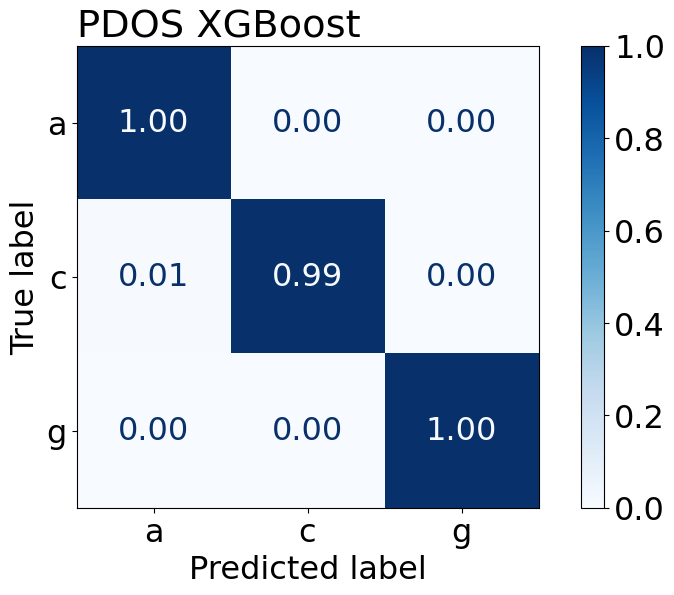

Learn(xgb--output/baoso3//magstr/dos_dt1f-0-0_bins100_eta0.500_tol1.000.csv) : 0.763070s
accuracy = 2739/3660 = 0.7484


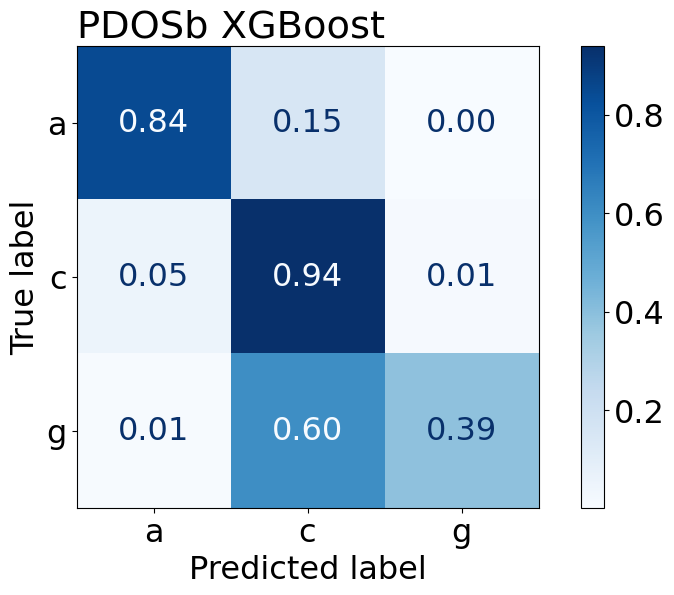

Learn(lgb--output/baoso3//magstr/dos_dt1f-0-0_bins100_eta0.500_tol1.000.csv) : 0.865442s
accuracy = 3652/3660 = 0.9978


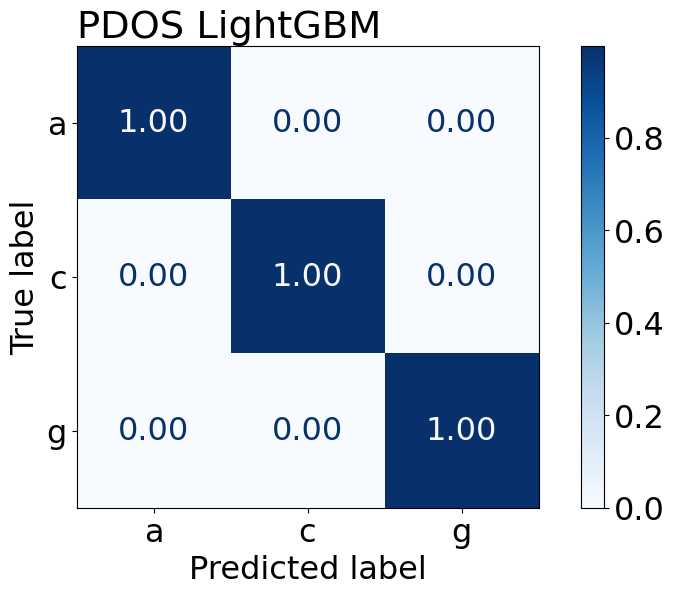

Learn(lgb--output/baoso3//magstr/dos_dt1f-0-0_bins100_eta0.500_tol1.000.csv) : 0.862393s
accuracy = 2782/3660 = 0.7601


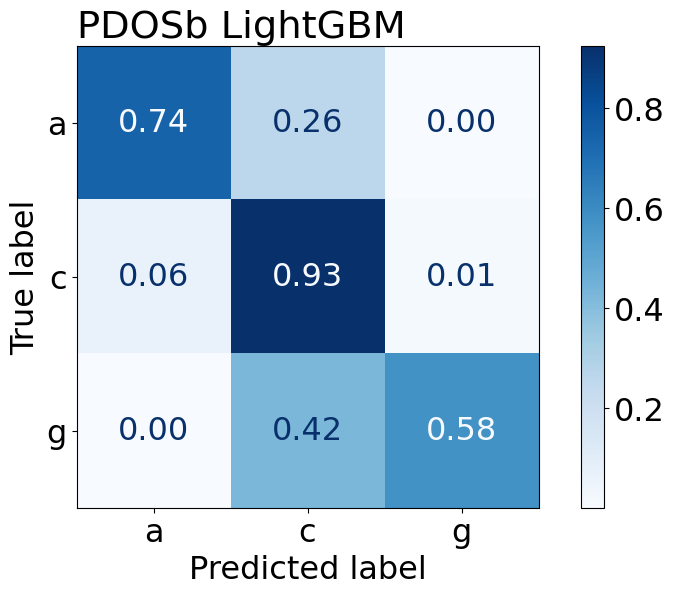

Learn(cat--output/baoso3//magstr/dos_dt1f-0-0_bins100_eta0.500_tol1.000.csv) : 5.124149s
accuracy = 3653/3660 = 0.9981


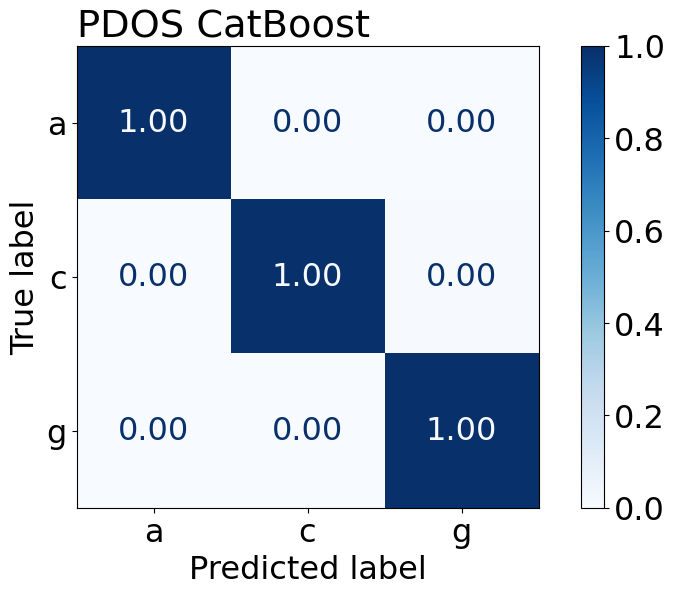

Learn(cat--output/baoso3//magstr/dos_dt1f-0-0_bins100_eta0.500_tol1.000.csv) : 5.110559s
accuracy = 3037/3660 = 0.8298


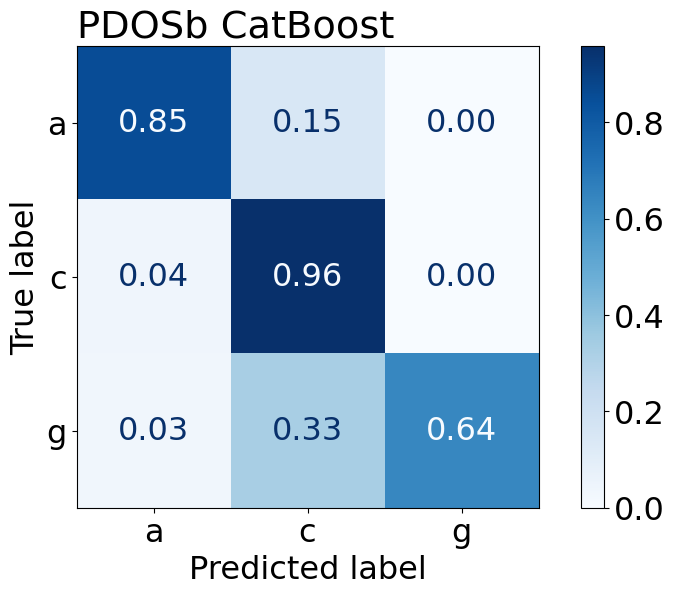

In [314]:
mcn = [['xgb', 'XGBoost'],
       ['lgb', 'LightGBM'],
       ['cat', 'CatBoost'],
      ]

for name, name_full in mcn:
    Applicate('1f-0-0', '1f-0-0', 100, 0.5, 1.0, name, '', 'PDOS ' + name_full)
    Applicate('1f-0-0', '1fb-0-0', 100, 0.5, 1.0, name, '', 'PDOSb ' + name_full)

In [234]:
def DrawSpec(broaden=False):
    bn = 'output/baoso3/JU0.00_SOC0.00/band_a_N8.0_U2.0_n7.9988906533761863_m3.2224019120483076_e91.2398987522744847_gap0.0005711889036331_fermi12.4343621937804478_dntop12.4338505062087137_122003.txt'
    un = 'output/baoso3/JU0.00_SOC0.00/ufw_a_N8.0_U2.0_n7.9988906533761863_m3.2224019120483076_e91.2398987522744847_gap0.0005711889036331_fermi12.4343621937804478_dntop12.4338505062087137_122003.txt'
    b = open(bn, 'r')
    u = open(un, 'r')
    band = np.genfromtxt(b)
    ufw = np.genfromtxt(u)
    b.close()
    u.close()
    
    band = band - 12.4338505062087137
    e_min = band.min()
    e_max = band.max()
    e_range = np.linspace(e_min, e_max, 100)
    
    w_fermi = [1 if e < 0 else 0 for e in e_range]
    
    if broaden:
        eta_list = [0.1 + e/e_min if e < 0 else 0.1 + e/e_max for e in e_range]
    else:
        eta_list = [0.5 for _ in e_range]
    
    z = pd.DataFrame()
    
    for i in range(len(band)):
        for e, eta, w in zip(e_range, eta_list, w_fermi):
            dos_list = [i, e]
            dos = 0
            for j in range(len(band[i])):
                dos += (eta / ((e - band[i][j])**2 + eta**2)) * ufw[i][j] * w
            dos_list.append(dos / np.pi)
            data = pd.DataFrame([dos_list], columns=['path', 'e', 'z'])
            z = pd.concat([z, data], sort=False)
            
    return z
    
z1 = DrawSpec(False)
z2 = DrawSpec(True)

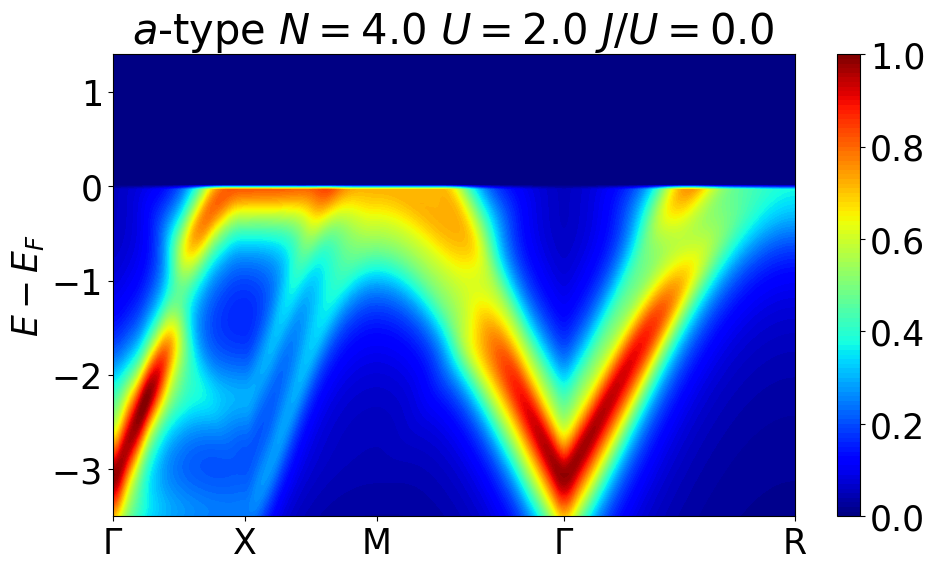

In [301]:
x = z1['path'].values.reshape(1024, 100)
y = z1['e'].values.reshape(1024, 100)
z = z1['z'].values.reshape(1024, 100)
z = z / z.max()

fig, ax = plt.subplots(figsize=(11, 6))
ct = ax.contourf(x, y, z, levels=100, cmap='jet')
cb = fig.colorbar(ct)
cb.set_ticks(np.arange(0, 1.1, 0.2))
ax.set_xticks([0, 198, 396, 677, 1023])
ax.set_xticklabels([r'$\Gamma$', 'X', 'M', r'$\Gamma$', 'R'])
ax.set_ylabel(r'$E - E_F$')
ax.set_title(r'$%s$-type $N = %.1f$ $U = %.1f$ $J/U = %.1f$' % ('a', 4, 2, 0))
plt.show()

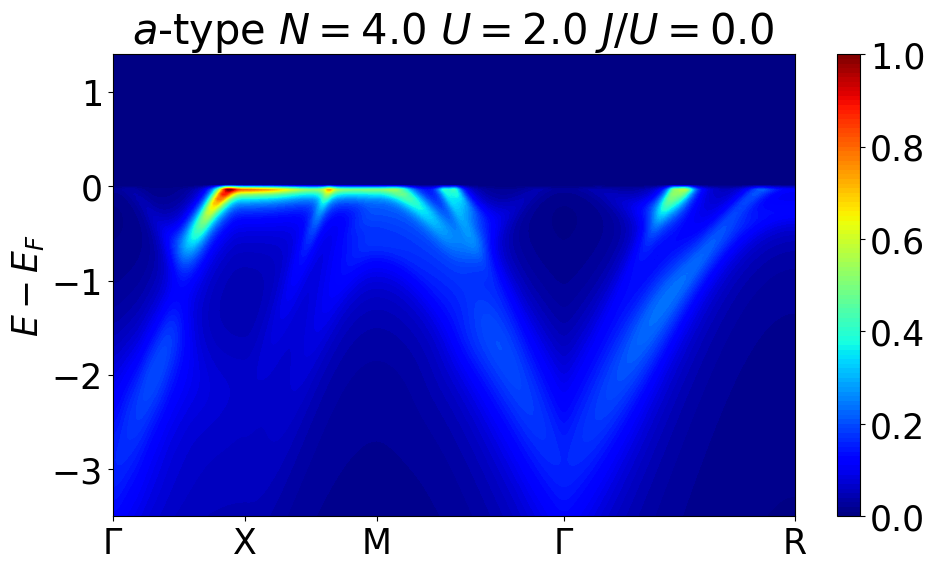

In [302]:
x = z2['path'].values.reshape(1024, 100)
y = z2['e'].values.reshape(1024, 100)
z = z2['z'].values.reshape(1024, 100)
z = z / z.max()

fig, ax = plt.subplots(figsize=(11, 6))
ct = ax.contourf(x, y, z, levels=100, cmap='jet')
cb = fig.colorbar(ct)
cb.set_ticks(np.arange(0, 1.1, 0.2))
ax.set_xticks([0, 198, 396, 677, 1023])
ax.set_xticklabels([r'$\Gamma$', 'X', 'M', r'$\Gamma$', 'R'])
ax.set_ylabel(r'$E - E_F$')
ax.set_title(r'$%s$-type $N = %.1f$ $U = %.1f$ $J/U = %.1f$' % ('a', 4, 2, 0))
plt.show()

In [ ]:
df_mis0 = GetIdx0(df_mis)
df_mis0

In [ ]:
for i in df_mis0.index:
    data = df_mis0.loc[i, :]
    dr = draw.Draw(path_input, path_output, info_path, info_cell, data['JU'], data['SOC'])
    dr.DrawBandDOS(data['type'], data['N'], data['U'], 1)
    dr.DrawBandDOS(data['type_f'], data['N'], data['U'], 1)
    print('-----------------------')

In [ ]:
lists = [(0, 0), (1, 10), (2, 10)]
dfs = []
dfms = []

tol = 1e-3
bins = 100
eta = 0.5

for (i, j) in lists:
    m = magstr.ML(path_output, info_path, info_cell, i, j)
    info = 'ptype%d num%d tol%.3f' % (i, j, tol)
    title = '%s bins%d eta%.1f' % (info, bins, eta)
    
    # df
    df, e_label, w_label, p_label = m.OpenBand(tol)
        
    # RF
    acc, y_test, y_pred, y_score = m.DoRandomForest(tol, bins, eta)
    print(acc)
    
    # dfm
    mis_list = []
    f_list = []
    for i, y_true in enumerate(y_test):
        if(y_true != y_pred[i]):
            mis_list.append(y_test.index[i])
            f_list.append(y_pred[i])
    dfm = df.loc[mis_list, :]
    
    # add False type at dfm
    dfm['type_f'] = 0
    for i, idx in enumerate(mis_list):
        dfm.loc[idx, 'type_f'] = f_list[i]
    
    df['type'] = df['type'].replace(types_dict)
    dfm['type'] = dfm['type'].replace(types_dict)
    dfm['type_f'] = dfm['type_f'].replace(types_dict)
    
    dfs.append([df, e_label, w_label, p_label, title])
    dfms.append([dfm, y_test, y_pred, title])

    DrawHist(df, e_label, info)
    DrawROC(y_test, y_score, title=title)
    DrawConfusionMatrix(y_test, y_pred, title=title)

In [ ]:
print(dfs[0][1])

In [ ]:
DrawInput(dfs[0][0], '')
DrawOutput(dfs[0][0], '')

In [ ]:
corr = dfs[0][0].loc[:, ['JU', 'N', 'U', 'm', 'dntop', 'gap']].corr()
sns.heatmap(corr, annot=True, fmt='.1f')

In [ ]:
for i in range(3):
    DrawMisType(dfms[i][0], dfms[i][-1])
    #DrawInput(dfms[i][0], dfms[i][-1])
    DrawOutput(dfms[i][0], dfms[i][-1])

In [ ]:
for i in range(3):
    df = dfms[i][0]
    print(df[df['m'] > 3.0])

In [ ]:
d = []
for i in range(4):
    di = draw.Draw(path_input, path_output, info_path, info_cell, 0.1*i, 0)
    d.append(di)

In [ ]:
d[0].DrawBandDOS('a', 8.0, 3.5)
d[0].DrawBandDOS('c', 8.0, 3.5)
d[0].DrawBandDOS('g', 8.0, 3.5)

In [ ]:
for i in [0, 1, 2]:
    for j in [0, 1, 2]:
        if j != i:
            df = dfms[0][0][(dfms[0][0]['type'] == i) & (dfms[0][0]['type_f'] == j)]
            print('type %d type_f %d' % (i, j), len(df), sep='\n')

In [ ]:
dfca = dfms[0][0][(dfms[0][0]['type'] == 1) & (dfms[0][0]['type_f'] == 0)]
DrawInput()

In [ ]:
DrawHist(0)
DrawHist(1)
DrawHist(2)

In [ ]:
plt.rcParams.update({'font.size': 18})

DrawHeatmap(path_output, 'magstr/acc_rf.csv')

In [ ]:
plt.rcParams.update({'font.size': 18})

DrawOptEta(path_output, 'magstr/acc_rf.csv', 40)

In [ ]:
plt.rcParams.update({'font.size': 16})

acc, y_test, y_pred = m.DoRandomForest(100, 0.4)
DrawConfusionMatrix(y_test, y_pred)

In [ ]:
y_test.iloc[0]

In [ ]:
df0, e_label, w_label, p_label = m.OpenBand()
mis_list = []
cor_list = []

for i, y_true in enumerate(y_test):
    if(y_true != y_pred[i]):
        mis_list.append(y_test.index[i])
    else:
        cor_list.append(y_test.index[i])
        
df_mis = df0.loc[mis_list, :]
df_cor = df0.loc[cor_list, :]
df_mis

In [ ]:
df_mis = df_mis.sort_values(by=['N', 'U'])
df_mis[p_label]